In [ ]:
!pip install plotnine networkx

In [1]:
# load autobounds components used in this demo
from autobounds.causalProblem import causalProblem
from autobounds.DAG import DAG
from autobounds.Query import Query

# load additional dependencies
import pandas as pd
import statsmodels.formula.api as smf
import plotnine as pn

# configure plotting options
pn.options.figure_size = (8, 4)

# Estimating treatment effects under post-treatment selection: <br>An introduction to `autobounds`

Kai Cooper, Guilherme Duarte, and Dean Knox

This notebook introduces `autobounds` (Duarte et al., 2023), a method for automatically drawing principled inferences in the presence of common imperfections in data and design. It illustrates how `autobounds` can be used to obtain sharp bounds—the narrowest possible range of conclusions consistent with available, imperfect information—by extending Knox, Lowe, and Mummolo (2020)'s analysis of racial bias in New York Police Department (NYPD) use of force.

- Section 1 introduces the empirical analysis of policing and its inherent selection issues, the running example in this notebook.
- Section 2 states the causal effects of interest to the analyst and describes various assumptions that analysts might use.
- Section 3 shows how to use `autobounds` to compute sharp bounds and probe sensitivity to assumptions. 

# 1. Design and data

Knox, Lowe, and Mummolo (2020) analyzes the use of force by NYPD officers in "stop, question, and frisk" encounters from 2003 to 2013, revisiting a prior analysis in Fryer (2019). The key question is whether minority civilians are subject to racial bias in the decision to use force.

For the purposes of this illustration, we will focus on one of many analyses in the paper: whether white ($D=0$) and black ($D=1$) civilians are subject to different amounts of force. For clarity of exposition, we will omit additional covariates on civilian gender, age, behavior, time, location, and so on. As the paper shows, conclusions remain substantively similar when adjusting for this information—more often than not, the addition of controls slightly strengthens the estimated disparities. In this exercise, we will define the outcome $Y=0$ to mean the use of no force and $Y=1$ as an officer's decision to use any amount of force, from the laying of hands on a civilian to more severe acts like the use of a baton or pepper spray. A variety of force thresholds are examined in the original paper.

The central methodological challenge identified in the paper is that analyses of police administrative stop records must inherently condition on the existence of a stop record, which depends on an officer's often-discretionary decision to initiate the stop, denoted $M$. 
In other words, every row in the data represents an police-civilian encounter in which a stop that was made ($M=1$), but encounters in which no stop was made ($M=0$) do not appear in the data. In fact, analysts do not even have information about the number of these non-stop encounters.

This stopping decision may itself be discriminatory, i.e. depend on civilian race. Moreover, this stopping decision also affects the use of force, because officers typically do not use force on civilians that they do not first detain. $M$ is therefore a mediator between the treatment $D$ and outcome $Y$. Therefore, the data is selected on a post-treatment variable that also mediates the effect of treatment. The paper argues that unobserved factors, $U$, are likely to jointly influence officers decisions to stop and use force. The theorized causal graph is shown below.

![image](images/klm_dag.png)

Next, we will present some exploratory analyses to introduce the data and design.

## 1.a. Load and inspect raw data

In this subsection, we will import the data and examine some summary statistics.

In [2]:
data = pd.read_csv("klm_demo_bw_anyforce.csv")

In [3]:
# 2,874,532 rows x 3 columns
data.shape

(2874532, 3)

In [4]:
# examine random sample
data.sample(5)

,D,M,Y
2272684,1,1,0
725635,1,1,0
1260001,0,1,0
460617,1,1,0
2843977,1,1,0


In [5]:
# examine 
data.mean()

D    0.857329
M    1.000000
Y    0.214302
dtype: float64

That is, 100% of encounters in the dataset involved a stop, due to the inherently selected nature of police administrative data. Of these stops, 86% were of Black civilians. Police officers used at least some force in 21% of all stops.

In [6]:
# count number of units with each combination of D, M, Y
(
    data
    .value_counts()
    .sort_values()    
)

D  M  Y
0  1  1      66182
      0     343930
1  1  1     549836
      0    1914584
Name: count, dtype: int64

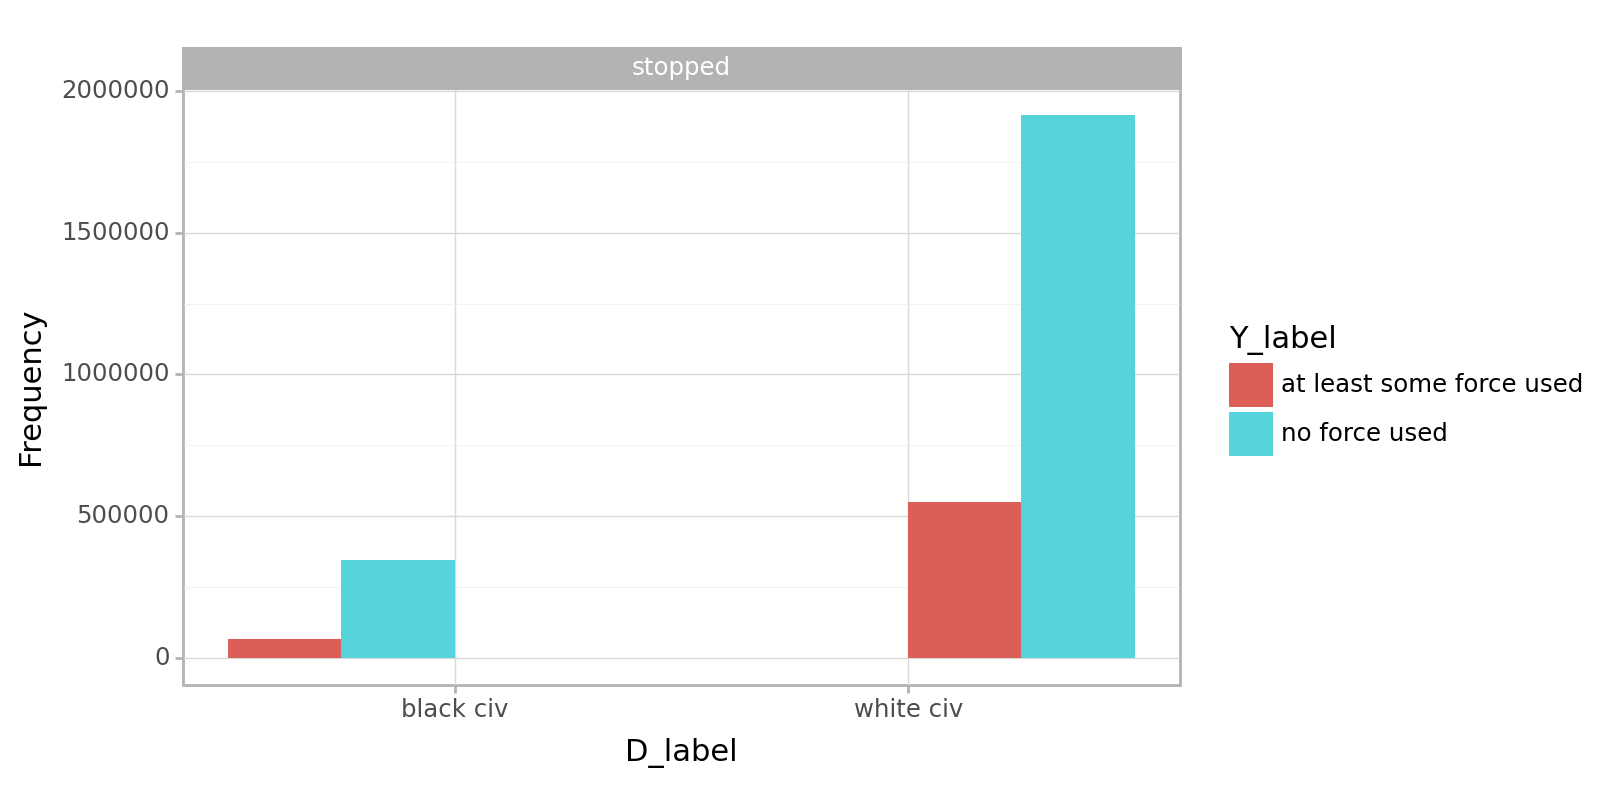

<Figure Size: (800 x 400)>

In [7]:
# generate informative variable names for plotting
data = data.assign(
    D_label = data.D.map({0 : "black civ", 1 : "white civ"}),
    M_label = data.M.map({0 : "not stopped", 1 : "stopped"}),
    Y_label = data.Y.map({0 : "no force used", 1 : "at least some force used"})
)

# create initial visualization
(
    pn.ggplot(data,
              pn.aes(x = "D_label",
                     fill = "Y_label"
                    )
             ) 
    + pn.facet_wrap("M_label")
    + pn.geom_histogram(binwidth = 1, position = 'dodge')
    + pn.ylab("Frequency")
    + pn.theme_light()
)

---

## 1.b. Conduct preliminary analyses

In this subsection, we will conduct a preliminary regression analysis that blindly ignores the presence of selection. This is the approach used in Fryer (2019).

In [8]:
# regression that blindly ignores selection 
model = smf.ols("Y ~ D", data = data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7980.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):               0.00
Time:                        05:44:22   Log-Likelihood:            -1.5142e+06
No. Observations:             2874532   AIC:                         3.028e+06
Df Residuals:                 2874530   BIC:                         3.029e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1614      0.001    252.203      0.000       0.160       0.163
D              0.0617      0.001     89.333      0.000       0.060       0.063
==============================================================================
Omnibus:                   539963.759   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           920931.891
Skew:                           1.386   Prob(JB):                         0.00
Kurtosis:                       2.937   Cond. No.                         5.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This regression suggests that, conditional on selection into the dataset, that black civilians are subject to slightly higher rates of force. However, a na&iuml;ve regression suggests that the difference is relatively small, roughly 6 percentage points.

---

## 1.c. Prepare summary statistics

Finally, we will preprocess the data. `autobounds` works with sufficient statistics that represent the proportion of units with each unique combination of values, so we will first compute these.

In [9]:
# count units with each unique combination of Z, X, Y 
data_summary = (
    data
    .loc[:, ['D', 'M', 'Y']]
    .value_counts()
    .rename('counts')
    .reset_index()
)
data_summary

,D,M,Y,counts
0,1,1,0,1914584
1,1,1,1,549836
2,0,1,0,343930
3,0,1,1,66182


In [10]:
# divide by the total to get the estimated probability of each type
data_summary = data_summary.assign(prob = data_summary.counts / data_summary.counts.sum())
data_summary

,D,M,Y,counts,prob
0,1,1,0,1914584,0.666051
1,1,1,1,549836,0.191278
2,0,1,0,343930,0.119647
3,0,1,1,66182,0.023024


---

# 2. Background, assumptions, and estimands

In this section, we provide brief background on the instrumental variables model, as well as a discussion of common assumptions and estimands.

## 2.a. Possible assumptions in analyzing police use of force

Knox, Lowe, and Mummolo (2020) discusses a number of assumptions that may be employed in the substantive context of police stops.

- **Mandatory reporting:** A plausible assumption is that all uses of force are reported on stop forms. This implies that if officers do not initiate a stop, then they do not go on to use force. Formally, $Y(D=d, M=0) = 0$ for all civilian races $d \in \{0, 1\}$.
- **Mediator monotonicity:** If officers discriminate in their stopping decisions, it is likely to be against black civilians. In other words, this assumption states that there is no anti-white discriminatory stopping. Formally, $M(D=1) \ge M(D=0)$.
- **Relative nonseverity of racial stops:** If officers would make different stopping decisions depending on civilian race, so that $M(D=0) \ne M(D=1)$ while holding all else equal, then the stop is by definition discretionary. In contrast, "always stop" encounters are those with $M(D=0) = M(D=1) = 1$. We cannot directly identify which encounters are of which types, but it is assumed that discretionary racial-stop encounters are less severe than always-stop encounters, in the sense that that officers would use less force on average (holding civilian race and stopping decisions fixed) in racial-stop encounters compared to always-stop encounters. Formally,
$\mathbb{E}[ Y(d, m) | \text{racial stop}] \le \mathbb{E}[ Y(d, m) | \text{always stop}]$.
- **Treatment ignorability:** Civilian race is "as good as randomly assigned" to encounters after adjusting for covariates (if any are used). Equivalently, black and white civilians appear in circumstances that are objectively no different. This is a structural causal assumption that is encoded in the unconfoundedness of $D$ in the causal graph. As the paper notes, "every study claiming to estimate racial discrimination using similar data makes this assumption, often implicitly. Our aim in this study is not to assert the plausibility of treatment ignorability, but rather to clarify that deep problems remain even if this well-known issue is somehow solved."

Next, the paper points out additional, implausible assumptions that prior work such as Fryer (2019) has used, often implicitly:
- **Mediator ignorability:** This states that officer stopping decisions are "as good as randomly assigned" after accounting for civilian race. Equivalently, it requires that there are no unobserved factors that jointly influence decisions to stop and use force (depicted as $U$ in the graph given in Figure 1). This is a structural assumption that rules out confounding of $M$. It makes little sense in the analysis of policing data, because numerous variables such as officer mental state are not recorded.
- **No racial stops:** This states that officers do not discriminate in the decision to stop. It is a structural assumption that rules out the existence of a $D \to M$ arrow in the graph. In a study of discrimination in one stage of policing (the decision to use force), it makes little sense to assume away discrimination im another stage (the decision to stop).

If either the mediator-ignorability or no-racial-stops assumptions are satisfied, then the common approach of running regressions that ignore selection will produce unbiased estimates of one particular causal estimand, discussed below. However, for the reasons identified, these are unlikely to hold in the context of policing.

---

## 2.b. Implicit estimands in analyses of police stop data

Researchers studying discrimination in police violence are interested in estimating an effect of civilian race, $D$, on police use of force, $Y$. However, in a detailed review of the literature, Knox, Lowe, and Mummolo (2020) identified no papers that explicitly identified the precise quantity of interest. Rather, the typical approach is to simply run a regression and informally gesture in the direction of a conclusion.

To formalize research objectives and assess whether commonly used methods are capable of achieving these objectives with selected data, Knox, Lowe, and Mummolo (2020) discuss a number of possible estimands that prior work may have targeted:
- **Average treatment effect** ($ATE$): The extent to which civilians of color face greater risk of police violence than white civilians because of their race, across all police-civilian encounters. This is a "total effect" that captures two related phenomena: first, whether members of the minority are differentially stopped; and second, if they are differentially subject to violence. A key challenge is that analysts do not know the proportion of this full population, all encounters, that are represented in the available data. Formally, it is $\mathbb{E}[Y(D=1, M(D=1)) - Y(D=0, M(D=0))]$.
- **Average treatment effect among the stopped** ($ATE_{M=1}$): The total effect *among the subgroup of encounters that appear in the data*. Conceptually, this involves "cross-world" reasoning in which analysts first identify the subgroup of interest using the real world, in terms of how officers made stopping decisions based on civilians' actual race. Then, analysts ask what the effect would be if the subgroup of interest were transported to an alternate world in which white or black civilians were randomized into these encounters, behaving in the same way. It is "cross world" because the subgroup of interest cannot be identified in the same world as the experiment. Despite this conceptual challenge, Knox, Lowe, and Mummolo (2020) concludes that this is the estimand most closely corresponding to how research is motivated and conclusions are interpreted in this literature. Formally, it is $\mathbb{E}[Y(D=1, M(D=1)) - Y(D=0, M(D=0)) | M=1]$.
- **Average treatment effect among the stopped and treated** ($ATT_{M=1}$): The total effect *among the subgroup of minority encounters that appear in the data*. This is analogous to the prior estimand, except that it excludes encounters with white civilians. Formally, it is $\mathbb{E}[Y(D=1, M(D=1)) - Y(D=0, M(D=0)) | D=1, M=1]$.
- **Controlled direct effect among the stopped** ($CDE_{M=1}$): This estimand differs from the $ATE_{M=1}$ in its conceptual approach to racially discriminatory stops. Where the $ATE_{M=1}$ asks whether a stop would have occurred at all if the individual were of differing race, the $CDE_{M=1}$ seeks to quantify what would have happened if the officer was forced to stop them anyway, perhaps against the officer's will. Formally, it is $\mathbb{E}[Y(D=1, M=1) - Y(D=0, M=1) | M=1]$.

Knox, Lowe, and Mummolo (2020) examine each of these estimands in turn and show that standard regressions using selected police data fail to recover any of them. In this demonstration, we will focus on bounds for the $ATE_{M=1}$, the formal estimand that most closely resembles the informal interpretation of prior results.

---

# 3. Bounding the $ATE_{M=1}$ under plausible assumptions with `autobounds`

In this section, we demonstrate the use of `autobounds` by computing sharp bounds on the $ATE_{M=1}$ using the same assumptions used by Knox, Lowe, and Mummolo (2020). In that paper, bounds were obtained analytically, taking roughly 10 weeks of manual algebraic manipulation to derived and 15 pages of appendices to present.

To do the same with `autobounds`, we will simply state each piece of the causal-inference problem we would like to solve. A problem is defined by five elements:
- The causal graph, or structural assumptions relating the variables
- The sample space, or the number of unique values that each variable can take on
- Additional functional-form assumptions justified by domain expertise
- The empirical evidence, or the data
- The quantity of interest, or the estimand

The following subsections present code for each of these in turn.

## 3.a. Defining the causal graph

In this section, we will present a step-by-step demonstration of `autobounds`. As a working example, we will compute sharp bounds on the $ATE_{M=1}$ under the mandatory reporting, mediator monotonicity, relative nonseverity, and treatment ignorability assumptions.

First, we will define the assumed directed acyclic graph (DAG). All of the plausible assumptions in this case are structural assumptions that can be represented in this graph. Instatiate an empty DAG via the `DAG` class within the package. Build the structure of the graph with the method `.from_structure()`, which takes two arguments: 
- `edges`: A comma-separated string listing pairs of connected nodes. E.g. `"A -> B, B -> C, U -> A, U -> B"`
- `unob`: A comma-separated string listing the nodes that are unobserved disturbances

The graph can then be visualized using its `.plot()` method.

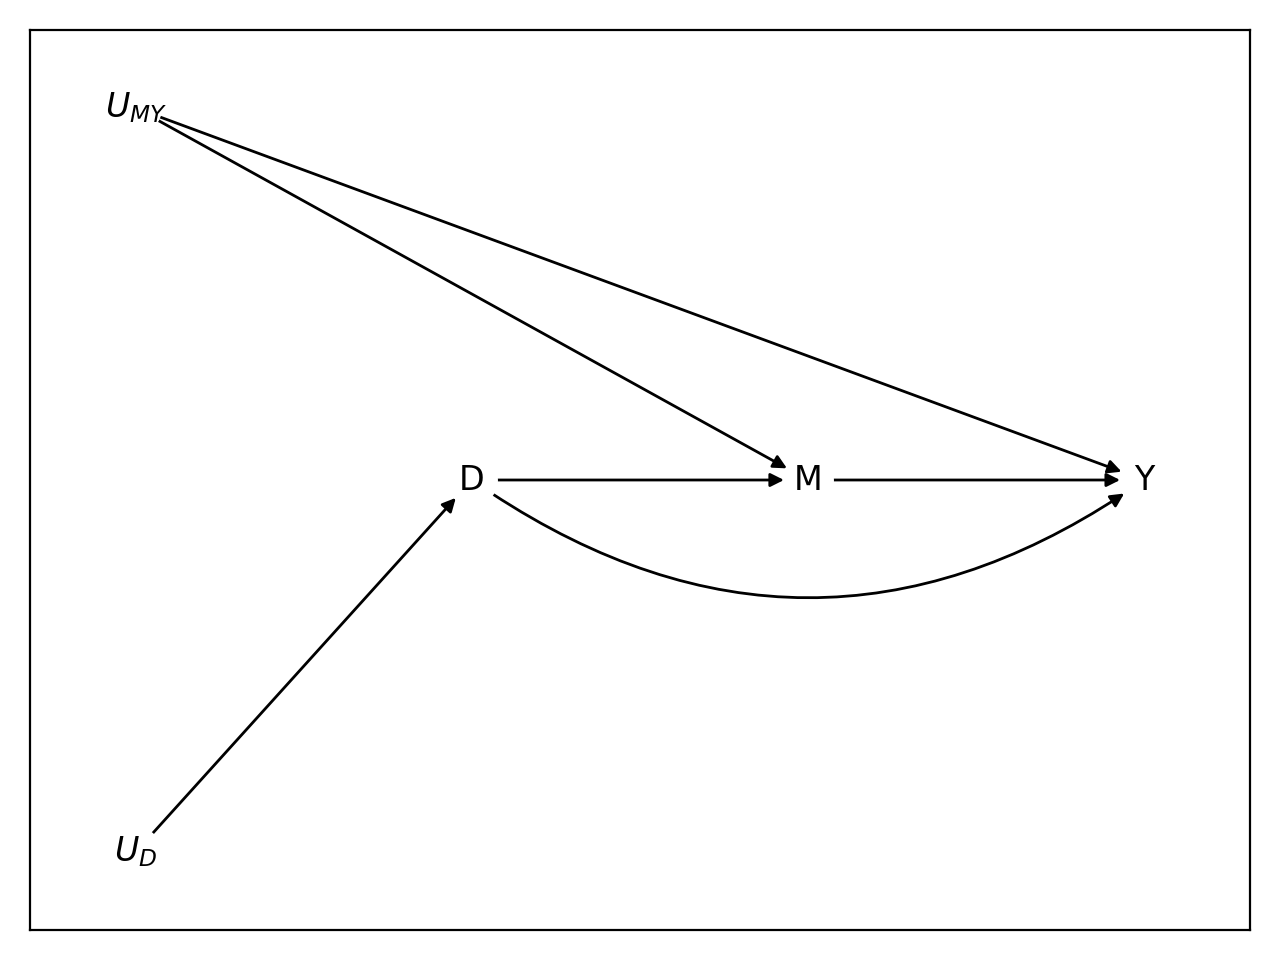

In [11]:
# first initialize an empty graph
graph = DAG()

# define edges and unobserved disturbances
graph.from_structure(
    edges = "Ud -> D, D -> M, D -> Y, M -> Y, Umy -> M, Umy -> Y",
    unob = "Ud, Umy"
)

# visualize the graph
graph.plot()

We will begin with the `causalProblem()` constructor, which takes two arguments:
- `graph`: the causal structure that the problem involves
- `number_values` (optional): a dictionary in which keys are variable names and values are variable cardinalities (binary, ternary, etc.). E.g. `"{A : 2, B: 3}`. If left unspecified, all variables are assumed to be binary.

In [12]:
# initialize a causal-inference problem involving the klm dag
problem = causalProblem(
    graph,
    number_values = {"D" : 2, "M" : 2, "Y" : 2}  # for illustration (not needed, same as defaults)
)

After initializing this problem, we next add the assumptions that `autobounds` should use.

Here, we will introduce the functional assumptions (mandatory reporting, mediator monotonicity, and relative nonseverity) using the `.add_constraint()` method. The fourth assumption, treatment ignorability, is a structural assumption that is already encoded in the causal graph.

We will begin with the mandatory reporting assumption, which can be stated nearly verbatim.

In [13]:
# assumption 1: if no stop is made, no force is used
force_used_without_stop = problem.query('Y(M=0)=1')    # define the group
problem.add_constraint(force_used_without_stop, '==')  # constrain group size (defaults to 0)

Next, we incorporate the mediator monotonicity assumption, which is also straightforward.

In [14]:
# assumption 2: if officers discriminate in stopping at all, it is likely against black civilians
anti_white_stop = problem.query("M(D=0)=1 & M(D=1)=0")  # define the group
problem.add_constraint(anti_white_stop, '==')           # constrain group size (defaults to 0)

The nonseverity assumption is more complex for two reasons:
1. it is assumed to hold for all $d \in \{0, 1\}$ and all $m \in \{0, 1\}$, meaning it is composed of separate assumptions for each combination of $d$ and $m$ and must be stated in a loop; and
2. it involves inequality statements about conditional probabilities, which will be easier when some planned functionalities are implemented, but currently requires a slight workaround.

In [15]:
# assumption 3: 

# define groups (anti-white stops are defined above)
always_stop = problem.query("M(D=0)=1 & M(D=1)=1")
anti_black_stop = problem.query("M(D=0)=0 & M(D=1)=1")

# for all d and m
for d in [0, 1]:
    for m in [0, 1]:
        
        # Pr[ force would counterfactually be used under this d and m AND encounter belongs to this group ]
        potential_force_dm_and_always_stop = problem.query("Y(D={d},M={m})=1 & M(D=0)=1 & M(D=1)=1".format(d=d, m=m))
        potential_force_dm_and_anti_black_stop = problem.query("Y(D={d},M={m})=1 & M(D=0)=0 & M(D=1)=1".format(d=d, m=m))
        potential_force_dm_and_anti_white_stop = problem.query("Y(D={d},M={m})=1 & M(D=0)=1 & M(D=1)=0".format(d=d, m=m))

        # # by Bayes' rule:
        # # Pr[ force would counterfactually be used under this d and m | encounter belongs to this group ]
        # # == Pr[ force would counterfactually be used under this d and m AND encounter belongs to this group ] /
        # #    Pr[ encounter belongs to this group ]
        # potential_force_dm_cond_always_stop = potential_force_dm_and_always_stop / always_stop
        # potential_force_dm_cond_anti_black_stop = potential_force_dm_and_anti_black_stop / anti_black_stop
        # potential_force_dm_cond_anti_white_stop = potential_force_dm_and_anti_white_stop / anti_white_stop
        # # this uses functionality that has not yet been implemented: division operator will be available in a future version
        #        
        # # assumption 3 as stated:
        # problem.add_constraint(potential_force_dm_cond_anti_black_stop, "<=", potential_force_dm_cond_always_stop)
        # problem.add_constraint(potential_force_dm_cond_anti_white_stop, "<=", potential_force_dm_cond_always_stop)
        # # this uses functionality that has not yet been implemented: right-hand-side variables will be available in a future version

        # using functionality that is currently available, the following is an equivalent but slightly more clunky workaround
        problem.add_constraint(
            potential_force_dm_and_anti_black_stop * always_stop - potential_force_dm_and_always_stop * anti_black_stop,
            "<=" 
            # defaults to 0
        )
        problem.add_constraint(
            potential_force_dm_and_anti_white_stop * always_stop - potential_force_dm_and_always_stop * anti_white_stop,
            "<=" 
            # defaults to 0
        )
        # this is equivalent because
        #   potential_force_dm_and_anti_xxx_stop / anti_xxx_stop <= potential_force_dm_and_always_stop / always_stop
        #   is equivalent to potential_force_dm_and_anti_x_stop * always_stop <= potential_force_dm_and_always_stop * anti_x_stop
        #   is equivalent to potential_force_dm_and_anti_x_stop * always_stop - potential_force_dm_and_always_stop * anti_x_stop <= 0

In addition to these assumptions based on substantive knowledge of a problem, analysts may wish to incorporate side information based on previous research. For example, previous work by Gelman, Fagan, and Kiss (2007) implies that among black stops, at least 32% of black stops were racially discriminatory. This can be easily incorporated as an additional constraint.

In [16]:
# incorporating side information: proportion of black stops that would not have been made if white
black_and_stop = problem.query("D=1 & M=1")
black_and_stop_and_discriminatory = problem.query("D=1 & M=1 & M(D=0)=0")
lower_bound_on_prop_black_stops_discriminatory_gfk07 = Query(0.32)

# # by Bayes' rule:
# # Pr[ would not stop if white | black AND stopped ]
# # == Pr[ black AND stopped AND would not stop if white ] / Pr[ black AND stopped ]
# discriminatory_cond_black_and_stop = black_and_stop_and_discriminatory / black_and_stop
# # this uses functionality that has not yet been implemented: division operator will be available in a future version
#
# incorporating the side information:
# problem.add_constraint(discriminatory_cond_black_and_stop, ">=", lower_bound_on_prop_black_stops_discriminatory_gfk07) 
# # this uses functionality that has not yet been implemented: right-hand-side variables will be available in a future version

# using functionality that is currently available, the following is an equivalent but slightly more clunky workaround
problem.add_constraint(
    black_and_stop_and_discriminatory - 
    lower_bound_on_prop_black_stops_discriminatory_gfk07 * black_and_stop,
    ">="
    # defaults to 0
)
# this is equivalent because
#   black_and_stop_and_discriminatory / black_and_stop >= 0.32
#   is equivalent to black_and_stop_and_discriminatory >= 0.32 * black_and_stop
#   is equivalent to black_and_stop_and_discriminatory - 0.32 * black_and_stop >= 0

Currently, we also need to tell `autobounds` about the laws of probability. This is done with the `.add_prob_constraints()` method, but will be automated in the next update.

In [17]:
# tell autobounds about the laws of probability
# (in a future update this will be handled automatically)
problem.add_prob_constraints()

The second to last step is to tell `autobounds` about the empirical evidence. The `.load_data()` method accepts summary statistics in the form of a `pandas` `DataFrame` object or a path to a CSV file. It accepts a second, optional argument, `cond`, containing a list of the variables on which the data are conditioned. In this case, all summary statistics are conditional on $M$ (specifically, $M=1$), so the argument `cond = ["M"]` is supplied.

Regardless of the input format, this must contain (i) one column per variable measured in the dataset, (ii) one row per unique combination of values, and (iii) an additional column named "prob" indicating the proportion of units of this type. An example is given in `data_summary` above.

In [18]:
# load in the data
problem.load_data(data_summary, cond = ["M"])

The last step is to define the quantity of interest: the ATE of race ($D$) on use of force ($Y$), conditional on a stop having been made ($M=1$). Below, three arguments are provided to the `.set_ate()` method:
- `ind`: the name of the independent variable, or treatment
- `dep`: the name of the dependent variable, or outcome
- `cond`: the subgroup of interest, identified through a separate `.query()` of the problem

In [19]:
# for numerical stability, currently we need to add a constraint that the subgroup of interest has nonzero size
# this will be made automatic in a future version
stop = problem.query("M=1")
small_positive_number = Query(.01)
problem.add_constraint(stop - small_positive_number, ">=")  # defaults to 0

problem.set_ate(ind = "D", dep = "Y", cond = "M=1")

Finally, we are ready to compute bounds. To do so, we will first translate the completely specified causal-inference problem into an equivalent *optimization program*. Solving this program with a numeric optimizer (like SCIP in the example below) will produce the desired sharp bounds.

In [20]:
# translate causal inference problem into optimization program
program = problem.write_program()

In [21]:
program.to_pip('klm_baseline.pip')

In [22]:
# to speed up demo, stop early before bounds are completely sharp (which would be epsilon = 0)
# with verbose = True, autobounds will periodically report progress on 
# - upper and lower bounding problems (the "dual" bounds are the guaranteed-valid causal bounds)
# - width of the guaranteed-valid causal bounds (theta = upper bound - lower bound)
# - proportion of those bounds that might be narrowed with further computation (epsilon)
results = program.run_scip(verbose = True, epsilon = .1)

UPPER BOUND: # -- Primal: 0.3107266 / Dual: nan / Time: 0.3 ##
LOWER BOUND: # -- Primal: 0.1060069 / Dual: -3598819000000000.0 / Time: 5.5 ##
UPPER BOUND: # -- Primal: 0.3107266 / Dual: 6967280000000000.0 / Time: 5.5 ##
CURRENT THRESHOLDS: # -- Theta: 1.0566099e+16 / Epsilon: 5.16125170171703e+16 ##
LOWER BOUND: # -- Primal: 0.1060069 / Dual: -312440.5 / Time: 10.5 ##
UPPER BOUND: # -- Primal: 0.3107266 / Dual: 4476984.0 / Time: 10.4 ##
CURRENT THRESHOLDS: # -- Theta: 4789424.5 / Epsilon: 23395033.7719345 ##
LOWER BOUND: # -- Primal: 0.1060069 / Dual: -3536.835 / Time: 15.5 ##
UPPER BOUND: # -- Primal: 0.3107266 / Dual: 11804.99 / Time: 15.4 ##
CURRENT THRESHOLDS: # -- Theta: 15341.825 / Epsilon: 74939.6383459921 ##
LOWER BOUND: # -- Primal: 0.1060069 / Dual: -2791.273 / Time: 20.5 ##
UPPER BOUND: # -- Primal: 0.3107266 / Dual: 11183.53 / Time: 20.3 ##
CURRENT THRESHOLDS: # -- Theta: 13974.803 / Epsilon: 68262.10804480467 ##
LOWER BOUND: # -- Primal: 0.1060069 / Dual: -1967.785 / Time:

In [24]:
"Based on these data and assumptions, the ATE_(M=1) is in the range [{lower:0.3f}, {upper:0.3f}]".format(
    lower = results[0]["dual"],  # index [0] selects lower bound, key ["dual"] selects guaranteed-valid bound
    upper = results[1]["dual"],  # index [1] selects upper bound, key ["dual"] selects guaranteed-valid bound
)

'Based on these data and assumptions, the ATE_(M=1) is in the range [0.104, 0.331]'

In other words, based on assumptions that are highly plausible, analysts can determine that the effect of the treatment is strongly positive, despite the issues noted. Moreover, it is larger than the 0.061 value suggested by the na&iuml;ve regression that ignored selection.

# References

Guilherme Duarte, Noam Finkelstein, Dean Knox, Jonathan Mummolo, and Ilya Shpitser. 2023. "An Automated Approach to Causal Inference in Discrete Settings," *Journal of the American Statistical Association* (Theory and Methods). https://doi.org/10.1080/01621459.2023.2216909

Andrew Gelman, Jeffrey Fagan, and Alex Kiss. 2007. "An Analysis of the New York City Police Department's 'Stop-and-Frisk' Policy in the Context of Claims of Racial Bias." *Journal of the American Statistical Association* (Applications and Case Studies). https://doi.org/10.1198/016214506000001040

Roland Fryer. 2019. "An Empirical Analysis of Racial Differences in Police Use of Force." *Journal of Political Economy*. https://doi.org/10.1086/701423

Dean Knox, Will Lowe, and Jonathan Mummolo. 2020. "Administrative Records Mask Racially Biased Policing," *American Political Science Review*. https://doi.org/10.1017/S0003055420000039
